# Geosilhouettes: geographical measures of cluster fit

See the [paper by Wolf, Knaap, & Rey (2019)](https://doi.org/10.1177%2F2399808319875752).
([preprint on SocArXiv](https://osf.io/preprints/socarxiv/vd3uk/))

In [1]:
import libpysal
import numpy
import esda
import geopandas
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
focus_states = numpy.array(["Alabama", "Mississippi", "Georgia"])
df = geopandas.read_file(libpysal.examples.get_path('south.shp'))\
              .query('STATE_NAME in @focus_states').reset_index()

In [3]:
from sklearn.metrics import silhouette_samples

In [4]:
states = df.STATE_NAME.unique().tolist()
df['label'] = df.STATE_NAME.apply(lambda x: states.index(x))

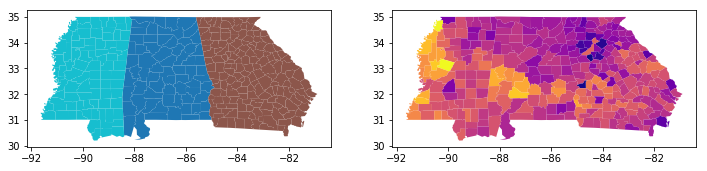

In [5]:
f,ax = plt.subplots(1,2, figsize=(12,3))
df.plot('STATE_NAME', ax=ax[0])
df.plot('GI89', ax=ax[1], cmap='plasma')

The standard silhouette score is composed of a few components: 
- $c$, the cluster in which $i$ is assigned
- $k$, another cluster in which $i$ is not currently assigned
- $d(i,c)$: the dissimilarity between observation $i$ and $i$'s own cluster $c$
- $d(i,k)$: the dissimilarity between observation $i$ and a cluster $k$ that $i$ is not in. 

Here, we define $d$ as an arbitrary dissimilarity metric. 

Then, we need to define the *second best choice cluster*, $\hat{k}$, which is a cluster that $i$ is most similar to, but of which $i$ is not currently a member:
$$\hat{k} = k\ | \min_k \{d(i,k)\}$$

This lets us define the silhouette score as the relationship between the dissimilarity scores for $i$ and its cluster $c$, and $i$ and the second-best choice cluster, $\hat{k}$:
$$ s_i = \frac{d(i,c) - d(i,\hat{k})}{\max\left\{d(i,c), d(i,\hat{k})\right\}}$$

This value is close to 1 when $i$ is much closer to its current cluster, $c$, than the second-best cluster, $\hat{k}$, indicating strong fit to its current cluster. And, when $i$ is more similar to $\hat{k}$ than to its own cluster $c$, the value of $s_i$ is close to -1. We can compute the score for each observation using `sklearn`'s `silhouette_samples`:

In [6]:
from sklearn.metrics import silhouette_samples
silhouettes = silhouette_samples(df[['GI89']].values, df.label)

Here, we can visualize that there is very strong heterogeneity in the Gini coefficient *within* states, because the silhouette statisic for each county is basically negative. 

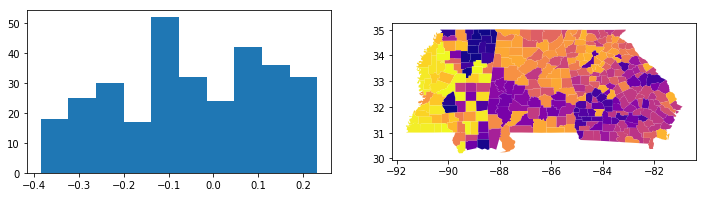

In [7]:
f,ax = plt.subplots(1,2,figsize=(12,3))
ax[0].hist(silhouettes)
df.plot(silhouettes, ax=ax[1], cmap='plasma')

# Nearest Label

/home/lw17329/anaconda3/envs/ana/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


Text(0.5, 1.0, 'Most similar other state to county')

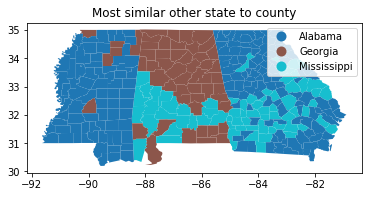

In [8]:
nearest_label = esda.nearest_label(df[['GI89']].values, df.label)
nearest_outside_state = focus_states[nearest_label]
ax = df.plot(nearest_outside_state, legend=True, categorical=True)
ax.set_title('Most similar other state to county')

/home/lw17329/anaconda3/envs/ana/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


Text(0.5, 1.0, 'Most similar other state to county')

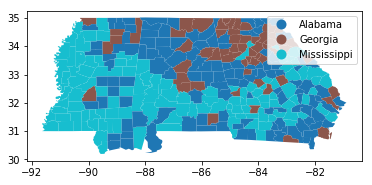

In [9]:
nearest_label = esda.nearest_label(df[['GI89']].values, df.label, keep_self=True)
nearest_state = focus_states[nearest_label]
df.plot(nearest_state, legend=True, categorical=True)
ax.set_title('Most similar other state to county')

# Geographical Structure

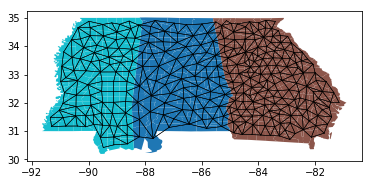

In [16]:
w = libpysal.weights.Rook.from_dataframe(df)
f,ax = w.plot(df, edge_kws=dict(linewidth=.5), 
              node_kws=dict(s=0))
df.plot('STATE_NAME', ax=ax)

# Path Silhouettes

In [20]:
path_silhouette = esda.path_silhouette(df[['GI89']].values, df.label, w)

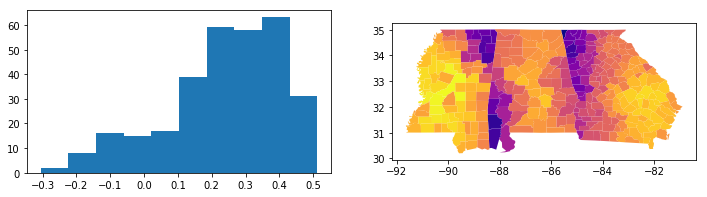

In [22]:
f,ax = plt.subplots(1,2,figsize=(12,3))
ax[0].hist(path_silhouette)
df.plot(path_silhouette, ax=ax[1], cmap='plasma')

# Boundary Silhouettes

In [36]:
boundary_silhouette = esda.boundary_silhouette(df[['GI89']].values, df.label, w)

In [37]:
df['boundary_silhouette'] = boundary_silhouette

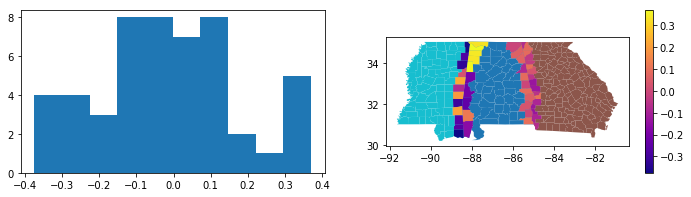

In [40]:
f,ax = plt.subplots(1,2,figsize=(12,3))
ax[0].hist(df.query('boundary_silhouette != 0').boundary_silhouette)
df.plot('STATE_NAME', ax=ax[1])
df.query('boundary_silhouette != 0')\
  .plot('boundary_silhouette', ax=ax[1], cmap='plasma', legend=True)